## 1. Data Loading

In [201]:
import json
import pandas as pd
import numpy as np
import string
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px

from calendar import monthrange
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

# Téléchargement des ressources pour le NLP (si nécessaire)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configuration Matplotlib pour une meilleure lisibilité
%matplotlib inline



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hadia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hadia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [178]:
from calendar import monthrange

def load_data(file_path, segment_key, years):
    """
    Load data from a JSON file and organize it into a DataFrame.
    
    Args:
        file_path (str): Path to the JSON file.
        segment_key (list): List of keys to extract from the JSON.
        years (list): List of years to extract data for.
    
    Returns:
        pd.DataFrame: DataFrame containing the loaded data.
    """
    try:
        with open(file_path, "r") as json_file:
            data = json.load(json_file)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return pd.DataFrame()
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")
        return pd.DataFrame()
    
    # Initialize an empty DataFrame
    df = pd.DataFrame(columns=["year", "month", "day", "url", "title"] + segment_key)
    
    # Extract data for each year, month, and day
    for year in years:
        for month in range(1, 13):
            # Get the number of days in the month
            _, num_days = monthrange(int(year), month)
            for day in range(1, num_days + 1):
                try:
                    # Check if the day exists in the data
                    if str(day) not in data['data'][str(year)][str(month)]:
                        continue
                    num = 0
                    while True:
                        try:
                            # Check if the article exists
                            if num >= len(data['data'][str(year)][str(month)][str(day)]):
                                break
                            data_tmp = data['data'][str(year)][str(month)][str(day)][num]
                            num += 1

                            # Create base data for the article
                            base_data = {
                                "year": year,
                                "month": month,
                                "day": day,
                                "url": data_tmp.get("url", ""),
                                "title": data_tmp.get("title", "")
                            }

                            # Extract segment data for each key
                            dict_tmp = {key: [] for key in segment_key}
                            for key in segment_key:
                                if key in data_tmp:
                                    for segment_data_tmp in data_tmp[key]:
                                        for segment_data in segment_data_tmp:
                                            dict_tmp[key].append(segment_data)
                                else:
                                    dict_tmp[key].append(None)

                            # Ensure all segments have the same length
                            max_length = max([len(value) for value in dict_tmp.values()])
                            for key in dict_tmp.keys():
                                while len(dict_tmp[key]) < max_length:
                                    dict_tmp[key].append(None)

                            # Add each segment to the DataFrame
                            for i in range(max_length):
                                new_data = base_data.copy()
                                for key in segment_key:
                                    new_data[key] = dict_tmp[key][i]
                                df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)

                        except KeyError:
                            break
                        except Exception as e:
                            print(f"Error processing data: {e}")
                            break
                except KeyError:
                    continue
    
    # Explode the 'content-segmented' column to handle lists
    df = df.explode("content-segmented", ignore_index=True)
    
    # Add a 'date' column for easier time-based analysis
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    
    # Print some statistics
    number_articles = df.shape[0]
    none_count = df['content-segmented'].isna().sum()
    print(f'Number of articles: {number_articles}')
    print(f"Number of None type in content-segmented: {none_count}")
    print(f'Percentage of None value in total: {100 * none_count / df.shape[0]:.2f} %')
    
    # Drop rows with None in 'content-segmented'
    df = df.dropna(subset=['content-segmented'])
    
    return df

# Load the data
file_path = "../data/raw/1eb80fb8b50.json"
segment_key = ["kws-l", "loc-l", "org-l", "per-l", "content-segmented"]
years = ["2024"]

df = load_data(file_path, segment_key, years)
df.head()

Number of articles: 3323
Number of None type in content-segmented: 0
Percentage of None value in total: 0.00 %


,year,month,day,url,title,kws-l,loc-l,org-l,per-l,content-segmented,date
0,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[monopolize, african, expert, financial, syste...",[],[BRICS],[],"""They're monopolizing everything"": African exp...",2024-02-29
1,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[world, banking, multinational, company, monop...",[Musawenkosi Mdluli],[World BRICS South Africa],[Sputnik Africa],World banking and multinational companies are ...,2024-02-29
2,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[world, banking, multinational, company, monop...",[],[],[],"""[...] World banking [...] and [...] multinati...",2024-02-29
3,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...",[control],[],[],[],Because now everything has been controlled by ...,2024-02-29
4,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[multipolar, system, affect, change, financial...",[Mdluli],[],[],[...] So the multipolar system will also affec...,2024-02-29


## 2. Text Cleaning

In [180]:
import re

def expand_contractions(text):
    """
    Expand English contractions in a text.
    
    Args:
        text (str): Input text with contractions.
    
    Returns:
        str: Text with contractions expanded.
    """
    # Common contractions and their expansions
    contractions = {
        "they're": "they are",
        "can't": "cannot",
        "won't": "will not",
        "don't": "do not",
        "it's": "it is",
        "i'm": "i am",
        "you're": "you are",
        "we're": "we are",
        "they've": "they have",
        "i've": "i have",
        "you've": "you have",
        "we've": "we have",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "hasn't": "has not",
        "haven't": "have not",
        "hadn't": "had not",
        "doesn't": "does not",
        "didn't": "did not",
        "wouldn't": "would not",
        "shouldn't": "should not",
        "couldn't": "could not",
        "let's": "let us",
        "that's": "that is",
        "who's": "who is",
        "what's": "what is",
        "where's": "where is",
        "when's": "when is",
        "why's": "why is",
        "how's": "how is"
    }
    
    # Replace contractions with their expanded forms
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text, flags=re.IGNORECASE)
    
    return text

In [181]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Télécharger les ressources nécessaires de NLTK (si ce n'est pas déjà fait)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    """
    Clean and preprocess a text segment.
    
    Args:
        text (str): Input text to clean.
    
    Returns:
        str: Cleaned text.
    """
    if not isinstance(text, str):
        return ""
    
    # Expand contractions
    text = expand_contractions(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Remove numbers (optional)
    text = re.sub(r"\d+", "", text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))  # Change to 'french' if needed
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization (optional)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = " ".join(tokens)
    
    return cleaned_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hadia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hadia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [182]:
# Apply the cleaning function to the 'content-segmented' column
df['cleaned_content'] = df['content-segmented'].apply(clean_text)

# Display the first few rows to check the results
df[['content-segmented', 'cleaned_content']].head()

,content-segmented,cleaned_content
0,"""They're monopolizing everything"": African exp...",monopolizing everything african expert financi...
1,World banking and multinational companies are ...,world banking multinational company monopolizi...
2,"""[...] World banking [...] and [...] multinati...",world banking multinational company monopolizi...
3,Because now everything has been controlled by ...,everything controlled
4,[...] So the multipolar system will also affec...,multipolar system also affect change financial...


## 3. Vectorization

In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text(texts, custom_stop_words=None, max_features=5000):
    """
    Convert a list of text documents into a TF-IDF matrix.
    
    Args:
        texts (list): List of cleaned text documents.
        custom_stop_words (list or None): List of stop words to remove.
        max_features (int): Maximum number of features (words) to keep.
    
    Returns:
        scipy.sparse.csr_matrix: TF-IDF matrix.
        list: List of feature names (words).
    """
    if isinstance(custom_stop_words, set) or isinstance(custom_stop_words, frozenset):
        custom_stop_words = list(custom_stop_words)  # Convert set to list
    
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words=custom_stop_words)
    
    # Fit and transform the texts
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    return tfidf_matrix, feature_names

# Custom stop words
custom_stop_words = {"africa", "sputnik", "telegram", "tiktok", "channel", "subscribe", "live"}  # Example

# Vectorize the cleaned text with custom stop words
tfidf_matrix, feature_names = vectorize_text(df['cleaned_content'], custom_stop_words=custom_stop_words)

# Display the shape of the TF-IDF matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Number of Features: {len(feature_names)}")


TF-IDF Matrix Shape: (3323, 5000)
Number of Features: 5000


## 4. Topic Modeling

In [184]:
# Display the top words for the first document
tfidf_dense = tfidf_matrix.toarray()
first_document = tfidf_dense[0]
top_words_indices = first_document.argsort()[-10:][::-1]  # Top 10 words
top_words = [feature_names[i] for i in top_words_indices]
top_scores = [first_document[i] for i in top_words_indices]

print("Top Words for the First Document:")
for word, score in zip(top_words, top_scores):
    print(f"{word}: {score:.4f}")

# Display the top words for the second document
second_document = tfidf_dense[1]
top_words_indices = second_document.argsort()[-10:][::-1]  # Top 10 words
top_words = [feature_names[i] for i in top_words_indices]
top_scores = [second_document[i] for i in top_words_indices]

print("\nTop Words for the Second Document:")
for word, score in zip(top_words, top_scores):
    print(f"{word}: {score:.4f}")

Top Words for the First Document:
monopolizing: 0.4627
everything: 0.3726
change: 0.3634
expert: 0.3606
financial: 0.3483
brics: 0.3247
system: 0.3025
african: 0.2584
abiy: 0.0000
able: 0.0000

Top Words for the Second Document:
world: 0.4954
musawenkosi: 0.2518
mdluli: 0.2397
banking: 0.2397
monopolizing: 0.2311
establishing: 0.2311
multinational: 0.2244
multipolar: 0.2104
ceo: 0.1958
sideline: 0.1861


In [186]:
def apply_lda(tfidf_matrix, n_components=5, random_state=42):
    """
    Apply Latent Dirichlet Allocation (LDA) to the TF-IDF matrix.
    
    Args:
        tfidf_matrix (scipy.sparse.csr_matrix): TF-IDF matrix.
        n_components (int): Number of topics to extract.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        sklearn.decomposition.LatentDirichletAllocation: Fitted LDA model.
        numpy.ndarray: Document-topic distribution.
    """
    # Initialize the LDA model
    lda = LatentDirichletAllocation(
        n_components=n_components,
        random_state=random_state,
        learning_method='online'
    )
    
    # Fit the model to the TF-IDF matrix
    lda.fit(tfidf_matrix)
    
    # Get the document-topic distribution
    doc_topic_dist = lda.transform(tfidf_matrix)
    
    return lda, doc_topic_dist

In [187]:
# Apply LDA to the TF-IDF matrix
n_topics = 5  # Number of topics to extract
lda_model, doc_topic_dist = apply_lda(tfidf_matrix, n_components=n_topics)

# Display the topics and their top words
def display_topics(model, feature_names, n_top_words=10):
    """
    Display the top words for each topic.
    
    Args:
        model: Fitted LDA model.
        feature_names (list): List of feature names (words).
        n_top_words (int): Number of top words to display for each topic.
    """
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(" ".join(top_words))

# Display the topics
display_topics(lda_model, feature_names)

Topic 0:
follow wyf ddgeopolitics slavyangrad islander stay geopolitics substack youtube dd
Topic 1:
country russia world russian said african say minister putin march
Topic 2:
russian ukrainian force defense region ministry military ukraine area join
Topic 3:
boost sputnikafrica matter opinion at includes httpstmeslavyangrad russiaukraine information news
Topic 4:
gaza israel palestinian vote capital news ceasefire rossiya segodnya israeli


In [189]:
# Assign the dominant topic to each document
df['dominant_topic'] = doc_topic_dist.argmax(axis=1)

# Display the first few rows with the dominant topic
df[['content-segmented', 'cleaned_content', 'dominant_topic']].head(10)

,content-segmented,cleaned_content,dominant_topic
0,"""They're monopolizing everything"": African exp...",monopolizing everything african expert financi...,1
1,World banking and multinational companies are ...,world banking multinational company monopolizi...,1
2,"""[...] World banking [...] and [...] multinati...",world banking multinational company monopolizi...,1
3,Because now everything has been controlled by ...,everything controlled,0
4,[...] So the multipolar system will also affec...,multipolar system also affect change financial...,1
5,👉 Read the full story,👉 read full story,1
6,Subscribe to @sputnik_africa,subscribe sputnikafrica,3
7,🔸 TikTok | Sputnik Africa | Boost us on Telegr...,🔸 tiktok sputnik africa boost u telegram 🔸,3
8,🇲🇿 Mozambique's president gets immunity by Lon...,🇲🇿 mozambique president get immunity london co...,1
9,"The ruling read that President Filipe Nyusi ""h...",ruling read president filipe nyusi immunity ju...,1


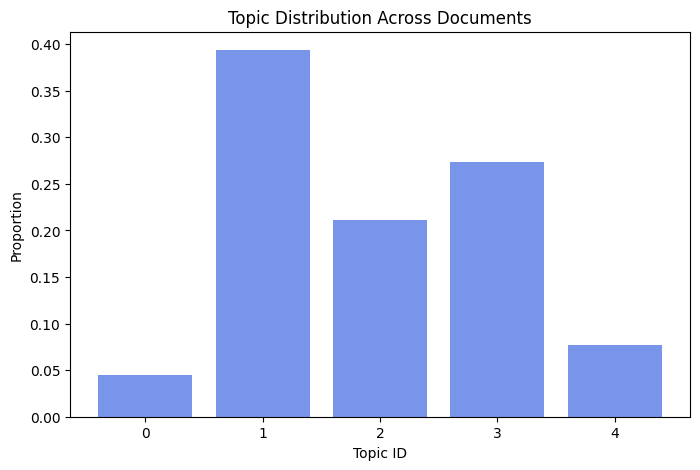

In [197]:
def plot_topic_distribution(lda_output, num_topics):
    """
    Plot the distribution of topics across all documents.
    
    Args:
        lda_output (numpy.ndarray): Topic distribution for each document.
        num_topics (int): Number of topics.
    """
    topic_counts = np.argmax(lda_output, axis=1)  # Get dominant topic for each document
    topic_distribution = np.bincount(topic_counts, minlength=num_topics) / len(topic_counts)

    plt.figure(figsize=(8, 5))
    plt.bar(range(num_topics), topic_distribution, color="royalblue", alpha=0.7)
    plt.xlabel("Topic ID")
    plt.ylabel("Proportion")
    plt.title("Topic Distribution Across Documents")
    plt.xticks(range(num_topics))
    plt.show()

# Visualisation de la distribution des topics
plot_topic_distribution(lda_model.transform(tfidf_matrix), lda_model.n_components)


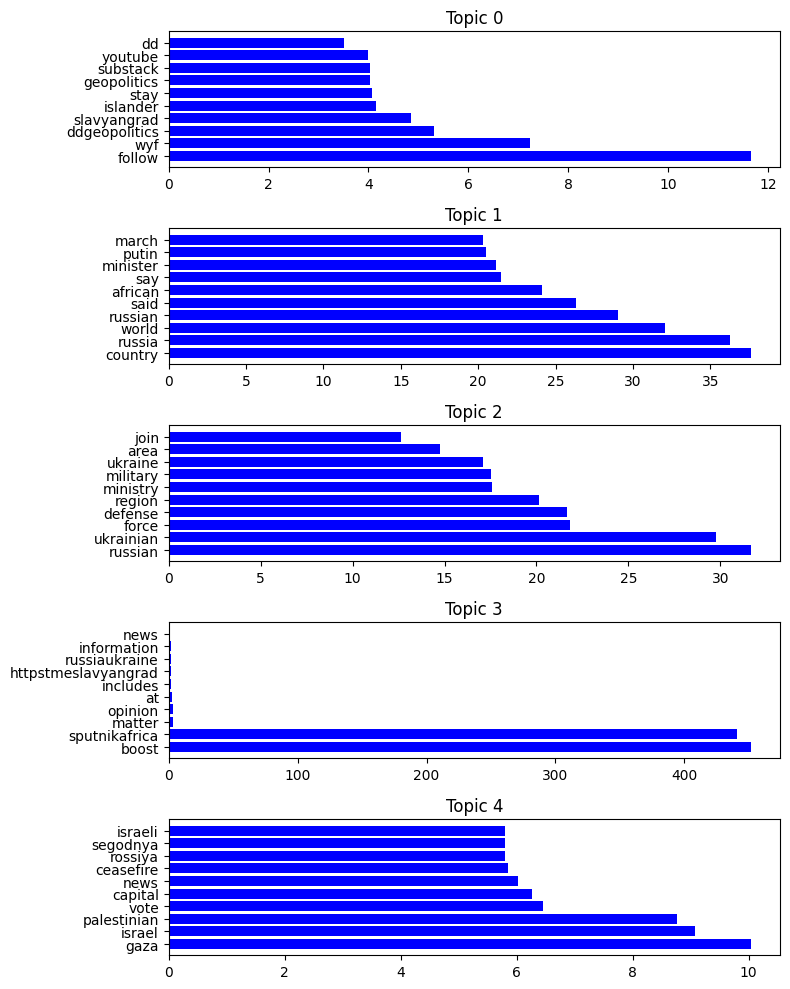

In [193]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words(lda, feature_names, n_top_words=10):
    """
    Plot the most important words in each topic as a bar chart.
    
    Args:
        lda (LatentDirichletAllocation): Trained LDA model.
        feature_names (list): List of feature names (words).
        n_top_words (int): Number of top words to display per topic.
    """
    num_topics = lda.n_components
    fig, axes = plt.subplots(num_topics, 1, figsize=(8, 2 * num_topics))
    
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_values = topic[topic.argsort()[:-n_top_words - 1:-1]]

        ax = axes[topic_idx]
        ax.barh(top_words, top_values, color='blue')
        ax.set_title(f"Topic {topic_idx}")

    plt.tight_layout()
    plt.show()

# Affichage des mots les plus importants par topic
plot_top_words(lda_model, feature_names)


In [198]:
# Define topic names based on word analysis
topic_names = {
    0: "Media & Geopolitical Analysis",
    1: "International Politics & Leadership",
    2: "Military & Defense",
    3: "News & Public Opinion",
    4: "Middle East & Israel-Palestine Conflict"
}

In [210]:
# Assign topic names to the DataFrame
df['topic_name'] = df['dominant_topic'].map(topic_names)

# Display the first few rows with topic names
df[['content-segmented', 'cleaned_content', 'dominant_topic', 'topic_name']].head()

,content-segmented,cleaned_content,dominant_topic,topic_name
0,"""They're monopolizing everything"": African exp...",monopolizing everything african expert financi...,1,International Politics & Leadership
1,World banking and multinational companies are ...,world banking multinational company monopolizi...,1,International Politics & Leadership
2,"""[...] World banking [...] and [...] multinati...",world banking multinational company monopolizi...,1,International Politics & Leadership
3,Because now everything has been controlled by ...,everything controlled,0,Media & Geopolitical Analysis
4,[...] So the multipolar system will also affec...,multipolar system also affect change financial...,1,International Politics & Leadership


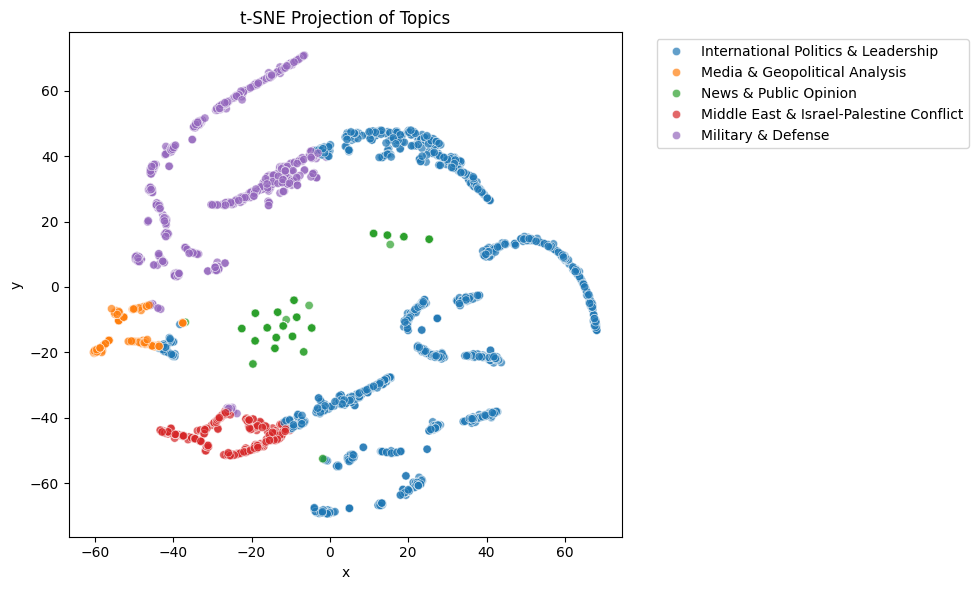

In [199]:
from sklearn.manifold import TSNE
import seaborn as sns



def plot_tsne(lda_output, topic_names):
    """
    Visualize LDA topics using t-SNE with topic names.
    
    Args:
        lda_output (numpy.ndarray): Topic distribution for each document.
        topic_names (dict): Dictionary mapping topic IDs to their names.
    """
    tsne_model = TSNE(n_components=2, random_state=42)
    tsne_lda = tsne_model.fit_transform(lda_output)

    # Convert to DataFrame
    df_tsne = pd.DataFrame(tsne_lda, columns=["x", "y"])
    df_tsne["topic"] = lda_output.argmax(axis=1)  # Assign each document to the most probable topic
    df_tsne["topic_name"] = df_tsne["topic"].map(topic_names)  # Map topic IDs to names

    # Scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="x", y="y", hue="topic_name", palette="tab10", data=df_tsne, alpha=0.7)
    plt.title("t-SNE Projection of Topics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualisation of topics in 2D with topic names
plot_tsne(lda_model.transform(tfidf_matrix), topic_names)


## 5. Graph Building

In [203]:
# Extract top words for each topic
topic_words = {
    topic_idx: [feature_names[i] for i in topic.argsort()[:-10-1:-1]] 
    for topic_idx, topic in enumerate(lda_model.components_)
}

# Vérification
print("✅ Topic Words Dictionary Created!")
print(topic_words)  # Affiche le dictionnaire des mots-clés par topic


✅ Topic Words Dictionary Created!
{0: ['follow', 'wyf', 'ddgeopolitics', 'slavyangrad', 'islander', 'stay', 'geopolitics', 'substack', 'youtube', 'dd'], 1: ['country', 'russia', 'world', 'russian', 'said', 'african', 'say', 'minister', 'putin', 'march'], 2: ['russian', 'ukrainian', 'force', 'defense', 'region', 'ministry', 'military', 'ukraine', 'area', 'join'], 3: ['boost', 'sputnikafrica', 'matter', 'opinion', 'at', 'includes', 'httpstmeslavyangrad', 'russiaukraine', 'information', 'news'], 4: ['gaza', 'israel', 'palestinian', 'vote', 'capital', 'news', 'ceasefire', 'rossiya', 'segodnya', 'israeli']}


In [206]:
import networkx as nx
from itertools import combinations
from pyvis.network import Network

def build_graph(df, topic_words, topic_names):
    """
    Build a keyword graph based on topic co-occurrence.
    
    Args:
        df (pd.DataFrame): DataFrame containing document-topic assignments.
        topic_words (dict): Dictionary mapping topic IDs to their top words.
        topic_names (dict): Dictionary mapping topic IDs to their names.
    
    Returns:
        nx.Graph: A graph where nodes are words and edges represent co-occurrences.
    """
    G = nx.Graph()

    # Add nodes: each unique word in topics becomes a node
    for topic_id, words in topic_words.items():
        for word in words:
            if not G.has_node(word):
                G.add_node(word, topic=topic_names[topic_id])

    # Add edges: words appearing in the same topic are connected
    for topic_id, words in topic_words.items():
        for word1, word2 in combinations(words, 2):  # Create pairs of words
            if G.has_edge(word1, word2):
                G[word1][word2]['weight'] += 1  # Increase weight if edge exists
            else:
                G.add_edge(word1, word2, weight=1, topic=topic_names[topic_id])  # Create new edge

    return G

# Construire le graphe
graph = build_graph(df, topic_words, topic_names)

# Vérifier le nombre de nœuds et d'arêtes
print(f"Graph Nodes: {graph.number_of_nodes()}, Graph Edges: {graph.number_of_edges()}")


Graph Nodes: 48, Graph Edges: 225


In [211]:
def build_graph(df, topic_names):
    """
    Build a graph of keywords with typed and weighted edges.
    
    Args:
        df (pd.DataFrame): DataFrame containing article data.
        topic_names (dict): Dictionary mapping topic IDs to their names.
    
    Returns:
        nx.Graph: Graph of keywords with typed and weighted edges.
    """
    G = nx.Graph()
    
    for _, row in df.iterrows():
        keywords = row["loc-l"] + row["org-l"] + row["per-l"]
        topic_name = topic_names.get(row['dominant_topic'], "unknown")
        
        # Add edges between keywords with the segment's topic
        for kw1, kw2 in combinations(keywords, 2):
            edge_key = (kw1, kw2, topic_name)
            if G.has_edge(kw1, kw2):
                G[kw1][kw2]["weight"] += 1
                G[kw1][kw2]["topics"][topic_name] = G[kw1][kw2]["topics"].get(topic_name, 0) + 1
            else:
                G.add_edge(kw1, kw2, weight=1, topics={topic_name: 1})
    
    return G

# Build the graph
G = build_graph(df, topic_names)

# Display the number of nodes and edges
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 1151
Number of Edges: 2914


In [212]:
from pyvis.network import Network

def visualize_graph(G):
    """
    Create an interactive visualization of the graph using PyVis.
    
    Args:
        G (nx.Graph): Input graph to visualize.
    """
    # Create a PyVis network
    net = Network(notebook=True, height="750px", width="100%")
    
    # Add nodes
    for node in G.nodes():
        net.add_node(node, title=node)
    
    # Add edges with topics and weights
    for edge in G.edges(data=True):
        node1, node2, data = edge
        topics = data.get("topics", {})
        label = ", ".join([f"{topic}: {count}" for topic, count in topics.items()])
        net.add_edge(node1, node2, weight=data["weight"], title=label)
    
    # Save and display the graph as an HTML file
    net.show("graph.html")

# Visualize the graph
visualize_graph(G)

graph.html


In [207]:
  """
    def visualize_graph(graph):
         # mettre le comment ici
        Visualize the keyword graph using PyVis.
        
        Args:
            graph (nx.Graph): The keyword graph.
        
        Returns:
            None
         # fin comment ici
        net = Network(notebook=True, height="800px", width="100%")
        
        for node in graph.nodes():
            net.add_node(node, label=node, title=node, color="lightblue")
        
        for edge in graph.edges(data=True):
            net.add_edge(edge[0], edge[1], value=edge[2]["weight"])

        net.show("graph.html")

    # Générer la visualisation interactive
    visualize_graph(graph)

"""

graph.html


## 6. save

In [208]:
output_path = "../data/processed/topic_graph.gexf"
nx.write_gexf(graph, output_path)

print(f"📂 Graph saved as GEXF at: {output_path}")

📂 Graph saved as GEXF at: ../data/processed/topic_graph.gexf
